In [1]:
%matplotlib inline

import GPy
import h5py
import json
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import os
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.interpolate import interp1d
import seaborn as sns

from util.load_hdf5 import *
from util.plot_roi import *
from util.compute_bounds import *
from util.plot_roi import *

directories = json.load(open('directories.json'))

In [2]:
imshow_p = {
    'cmap': 'RdBu_r',
    'vmin': -3,
    'vmax': 3,
}

In [3]:
sns.set_style('ticks')

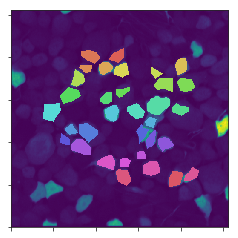

In [4]:
plot_roi(load_hdf5(directories['data'] + 'SMP_M1_LR_GCL0_HR.h5'))

In [5]:
ds_df = pd.read_csv(directories['data'] + 'SMP_M1_LR_GCL0_DS_r16.csv', index_col = 0)
ds_df = ds_df.groupby(['roi', 'frame']).mean().reset_index()

stimulus_sequence = [0, 180, 45, 225, 90, 270, 135, 315] * 3
stimulus_conditions = pd.DataFrame()
stimulus_conditions['Direction'] = stimulus_sequence
stimulus_conditions['trial'] = np.arange(0, 24, 1)

ds_df = ds_df.merge(stimulus_conditions)

ds_df['x_cos'] = np.cos(ds_df['Direction'] * 2 * np.pi / 360)
ds_df['x_sin'] = np.sin(ds_df['Direction'] * 2 * np.pi / 360)

 /usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:938: UserWarning:You are merging on int and float columns where the float values are not equal to their int representation


In [6]:
i_rois = np.unique(ds_df['roi'])

target_roi = i_rois[-1]

roi_df = ds_df.loc[ds_df['roi'] == target_roi, :]

x = roi_df['t']
x -= x.min()
y = roi_df['y']

trial_duration = (x.max() - x.min()) / 24

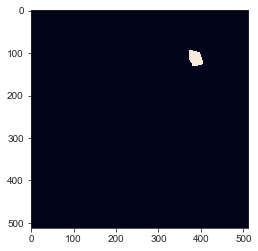

In [7]:
plt.imshow(load_hdf5(directories['data'] + 'SMP_M1_LR_GCL0_HR.h5')['ROIs'] == -1)

In [8]:
roi_df = ds_df.loc[ds_df['roi'] == i_rois[-1], :]

y = roi_df['y'].values[:, None]
X = np.concatenate([
        roi_df['x_t'].values[:, None],
        roi_df['x_cos'].values[:, None],
        roi_df['x_sin'].values[:, None]
], axis = 1)

In [9]:
roi_df = ds_df.loc[ds_df['roi'] == i_rois[-1], :]

y = roi_df['y'].values[:, None]
X = np.concatenate([
        roi_df['x_t'].values[:, None],
        roi_df['x_cos'].values[:, None],
        roi_df['x_sin'].values[:, None]
], axis = 1)

k = GPy.kern.RBF(1, active_dims = [0,]) + \
    GPy.kern.RBF(2, active_dims = [1, 2], ARD = True)

m = GPy.models.SparseGPRegression(X, y, kernel = k, num_inducing = 250)

m.optimize_restarts(1, messages = False, max_iters = 10)

Optimization restart 1/1, f = 2320.7205616190604


In [10]:
n_tpnts = 80
n_orientations = 16

X_predict_t = np.tile(np.linspace(0, 4, n_tpnts)[:, None], [1, n_orientations])
X_predict_phase = np.linspace(0, 2 * np.pi, n_orientations)
X_predict_cos = np.tile(np.cos(X_predict_phase)[None, :], [n_tpnts, 1])
X_predict_sin = np.tile(np.sin(X_predict_phase)[None, :], [n_tpnts, 1])

X_predict = np.concatenate([
    X_predict_t.flatten()[:, None],
    X_predict_cos.flatten()[:, None],
    X_predict_sin.flatten()[:, None],
], axis = 1)

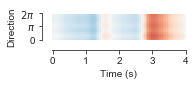

In [11]:
sns.set_style('ticks')

mu, sig = m.predict(X_predict, include_likelihood = False)

fig, ax = plt.subplots(1)

ax.imshow(mu.reshape(n_tpnts, n_orientations).T, **imshow_p)

plt.yticks([0, 8, 16])
ax.set_yticklabels(["0", "$\pi$", "$2\pi$"])
ax.set_ylim(0, 16)
ax.set_ylabel('Direction', fontsize = 10)

plt.xticks(np.arange(0, 100, 20))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2.4, 2)

plt.savefig(directories['figs'] + 'direction/' + 'Example TC wo. Multiplicative Effects.svg', dpi = 600)

In [12]:
k = GPy.kern.RBF(1, active_dims = [0,]) + \
    GPy.kern.RBF(2, active_dims = [1, 2], ARD = True) + \
    GPy.kern.RBF(1, active_dims = [0,]) * GPy.kern.RBF(2, active_dims = [1, 2], ARD = True)

m = GPy.models.SparseGPRegression(X, y, kernel = k, num_inducing = 250)

m.optimize_restarts(1, messages = True, max_iters = 10)

Optimization restart 1/1, f = 2131.9014453635546


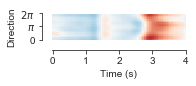

In [13]:
sns.set_style('ticks')

mu, sig = m.predict(X_predict, include_likelihood = False)

fig, ax = plt.subplots(1)

ax.imshow(mu.reshape(n_tpnts, n_orientations).T, **imshow_p)

plt.yticks([0, 8, 16])
ax.set_yticklabels(["0", "$\pi$", "$2\pi$"])
ax.set_ylim(0, 16)
ax.set_ylabel('Direction', fontsize = 10)

plt.xticks(np.arange(0, 100, 20))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2.4, 2)

plt.savefig(directories['figs'] + 'direction/' + 'Example TC w. Multiplicative Effects.svg', dpi = 600)

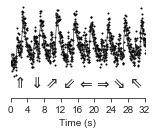

In [14]:
mu, sig = m.predict(X, include_likelihood = False)

fig, ax = plt.subplots(1)

ax.scatter(x, y, color = 'k', s = 1, marker = 'o')
ax.plot(x, mu, color = 'k', linewidth = 0.5)
upper, lower = compute_bounds(mu, sig, n_sigma = 3)
ax.fill_between(x, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.set_xlim(0, 32)
ax.set_ylim(-3, 3)
ax.set_xticks(np.arange(0, 36, 4))
ax.get_yaxis().set_visible(False)
sns.despine(left = True, ax = ax, offset = 10)
ax.set_xlabel('Time (s)', fontsize = 10);

stimulus_arrows = [r'$\Uparrow$',r'$\Downarrow$',r'$\Nearrow$',r'$\Swarrow$',
                  r'$\Leftarrow$',r'$\Rightarrow$',r'$\Searrow$',r'$\Nwarrow$',]

patch_offset = -3.
for itx in range(8):
    ax.annotate(
        stimulus_arrows[itx],
        xy=(itx * 4 + 1.8, patch_offset + 0.35), 
        fontsize = 15,
        horizontalalignment='center', 
        verticalalignment='center'
    )
    
fig.set_size_inches(2.4, 1.5)

plt.savefig(directories['figs'] + 'direction/' + 'Raw Data w. Fitted GP.svg', dpi = 600)

Compute GP for each ROI

In [15]:
mu_all, sig_all = [], []

for target_roi in i_rois:

    roi_df = ds_df.loc[ds_df['roi'] == target_roi, :]

    y = roi_df['y'].values[:, None]
    
    baseline_mask = roi_df['x_t'].values < 0.5
    y -= y[baseline_mask].mean()
    y /= y[baseline_mask].std()
    
    X = np.concatenate([
            roi_df['x_t'].values[:, None],
            roi_df['x_cos'].values[:, None],
            roi_df['x_sin'].values[:, None]
    ], axis = 1)
    

    k = GPy.kern.RBF(1, active_dims = [0,]) + \
    GPy.kern.RBF(2, active_dims = [1, 2], ARD = True) + \
    GPy.kern.RBF(1, active_dims = [0,]) * GPy.kern.RBF(2, active_dims = [1, 2], ARD = True)

    m = GPy.models.SparseGPRegression(X, y, kernel = k, num_inducing = 250)

    m.optimize_restarts(1, messages = False, max_iters = 10)

    mu, sig = m.predict(X_predict)
    
    mu_all.append(mu)
    sig_all.append(sig)

mu_all = np.hstack(mu_all)
mu_all = mu_all.reshape(n_orientations, n_tpnts, -1, order = 'f')
mu_all = np.swapaxes(mu_all, 0, 1)

Optimization restart 1/1, f = 4462.377678869482
Optimization restart 1/1, f = 4329.58069453133
Optimization restart 1/1, f = 4379.056502419342
Optimization restart 1/1, f = 3909.59686392009
Optimization restart 1/1, f = 3555.229509716156
Optimization restart 1/1, f = 4315.944540861384
Optimization restart 1/1, f = 3993.362759114284
Optimization restart 1/1, f = 4243.9528607022685
Optimization restart 1/1, f = 4399.340122232019
Optimization restart 1/1, f = 3788.494147471615
Optimization restart 1/1, f = 4414.188149920892
Optimization restart 1/1, f = 4208.648521556917
Optimization restart 1/1, f = 4247.476895833065
Optimization restart 1/1, f = 3885.2229357851415
Optimization restart 1/1, f = 4332.161569715488
Optimization restart 1/1, f = 6530.936841452847
Optimization restart 1/1, f = 4465.686925590079
Optimization restart 1/1, f = 5419.863935210125
Optimization restart 1/1, f = 4272.3759966906655
Optimization restart 1/1, f = 4159.202022797518
Optimization restart 1/1, f = 4635.7441

Filter GPs to identify those with best QC; Plot Heatmap For Each GP

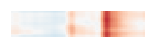

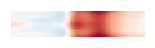

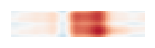

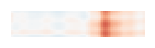

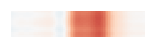

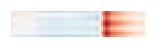

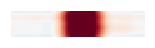

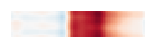

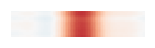

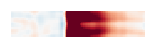

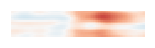

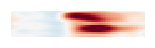

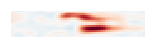

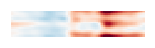

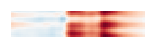

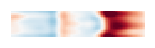

In [16]:
sns.set_style('white')

sd_filter = 2
filter_mask = []
label = 0
for itx in range(mu_all.shape[-1]):
    if np.any((mu_all[:, :, itx].T > sd_filter) | (mu_all[:, :, itx].T < -sd_filter)):
        filter_mask.append(True)
        fig, ax = plt.subplots(1)
        ax.imshow(mu_all[:, :, itx].T, cmap = 'RdBu_r', vmin = -4, vmax = 4)

        ax.set_yticklabels([]);
        ax.set_xticklabels([]);

        sns.despine(left = True, bottom = True, ax = ax)

        fig.set_size_inches(2.4, 2)
#         plt.savefig(directories['figs'] + 'direction/' + 'TC_{}.png'.format(label), dpi = 600)
#         label += 1

        plt.show()
        
    else:
        filter_mask.append(False)

In [18]:
mu_sset = mu_all[:, :, filter_mask]

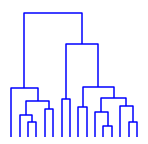

In [19]:
mu_flat = mu_sset.reshape(n_orientations * n_tpnts, -1, order = 'f')

Z = linkage(mu_flat.T, method = 'ward', metric = 'euclidean')

fig, ax = plt.subplots(1)

D = dendrogram(Z, color_threshold = 0, ax = ax)

fig.set_size_inches(2.4, 2.4)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

sns.despine(left = True, bottom = True, ax = ax)

plt.savefig(directories['figs'] + 'direction/' + 'Dendrogram.svg'.format(itx), dpi = 600)

In [20]:
mu_sorted = mu_sset[:, :, np.array(D['leaves'])]

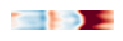

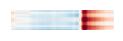

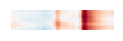

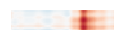

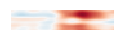

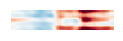

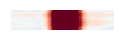

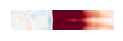

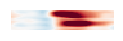

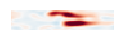

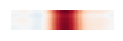

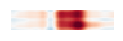

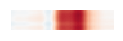

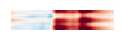

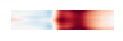

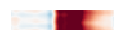

In [21]:
sns.set_style('white')

for itx in range(mu_sset.shape[-1]):
    fig, ax = plt.subplots(1)
    ax.imshow(mu_sorted[:, :, itx].T, **imshow_p)

    ax.set_yticklabels([]);
    ax.set_xticklabels([]);

    sns.despine(left = True, bottom = True, ax = ax)

    fig.set_size_inches(2.4, 0.6)
    
    plt.savefig(directories['figs'] + 'direction/' + 'TC_{}.png'.format(itx), dpi = 600)
    
    plt.tight_layout()
    plt.show()

In [22]:
mu_node, sig_node = [], []

for n_clusters in [2, 3, 4,]:
    mu_cluster, sig_cluster = [], []
    i_cluster = fcluster(Z, n_clusters, criterion = 'maxclust')
    
    for cluster in np.unique(i_cluster):

        cluster_df = ds_df.loc[ds_df['roi'].isin(i_rois[filter_mask][i_cluster == cluster]), :]

        y = cluster_df['y'].values[:, None]
        X = np.concatenate([
                cluster_df['x_t'].values[:, None],
                cluster_df['x_cos'].values[:, None],
                cluster_df['x_sin'].values[:, None]
        ], axis = 1)

        k = GPy.kern.RBF(1, active_dims = [0,]) + \
        GPy.kern.RBF(2, active_dims = [1, 2], ARD = True) + \
        GPy.kern.RBF(1, active_dims = [0,]) * GPy.kern.RBF(2, active_dims = [1, 2], ARD = True)
        
        m = GPy.models.SparseGPRegression(X, y, kernel = k, num_inducing = 250)

        m.optimize_restarts(1, messages = False, max_iters = 10)

        mu, sig = m.predict(X_predict, include_likelihood = False)

        mu_cluster.append(mu)
        sig_cluster.append(sig)
    
    mu_node.append(mu_cluster)
    sig_node.append(sig_cluster)

Optimization restart 1/1, f = 19224.46165151435
Optimization restart 1/1, f = 25727.020811216767
Optimization restart 1/1, f = 19232.350749537953
Optimization restart 1/1, f = 3725.4829386453475
Optimization restart 1/1, f = 20990.717395355026
Optimization restart 1/1, f = 19225.458110026535
Optimization restart 1/1, f = 3725.521875729174
Optimization restart 1/1, f = 5087.665530919541
Optimization restart 1/1, f = 14999.073610484355


Node 1

In [23]:
fcluster(Z, 2, criterion = 'maxclust')

array([1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1], dtype=int32)

In [24]:
fcluster(Z, 3, criterion = 'maxclust')

array([1, 3, 3, 1, 3, 1, 2, 3, 3, 2, 1, 3, 3, 1, 3, 1], dtype=int32)

In [25]:
fcluster(Z, 4, criterion = 'maxclust')

array([1, 4, 4, 1, 4, 1, 2, 4, 4, 2, 1, 3, 3, 1, 4, 1], dtype=int32)

In [26]:
n1_c1_mu = mu_node[0][0].reshape(n_tpnts, n_orientations)
n1_c1_sig = sig_node[0][0].reshape(n_tpnts, n_orientations)
n1_c2_mu = mu_node[0][1].reshape(n_tpnts, n_orientations)
n1_c2_sig = sig_node[0][1].reshape(n_tpnts, n_orientations)

n2_c1_mu = mu_node[1][1].reshape(n_tpnts, n_orientations)
n2_c1_sig = sig_node[1][1].reshape(n_tpnts, n_orientations)
n2_c2_mu = mu_node[1][2].reshape(n_tpnts, n_orientations)
n2_c2_sig = sig_node[1][2].reshape(n_tpnts, n_orientations)

n3_c1_mu = mu_node[2][2].reshape(n_tpnts, n_orientations)
n3_c1_sig = sig_node[2][2].reshape(n_tpnts, n_orientations)
n3_c2_mu = mu_node[2][3].reshape(n_tpnts, n_orientations)
n3_c2_sig = sig_node[2][3].reshape(n_tpnts, n_orientations)

In [27]:
from skimage.measure import label

In [121]:
n_sigma = np.linspace(0, 5, 50)

n1_blob = np.zeros(100)
n2_blob = np.zeros(100)
n3_blob = np.zeros(100)

for itx, sigma in enumerate(n_sigma):
    n1_diff_mu = n1_c1_mu - n1_c2_mu
    n1_diff_sig = n1_c1_sig + n1_c2_sig
    n1_diff_upper = n1_diff_mu + sigma * np.sqrt(np.abs(n1_diff_sig))
    n1_diff_lower = n1_diff_mu - sigma * np.sqrt(np.abs(n1_diff_sig))

    labels = label((n1_diff_lower.T > 0) | (n1_diff_upper.T < 0), 
                   neighbors = 8, background = 1)

    n1_blob[itx] = np.unique(labels).shape[0] - 1
    
    n2_diff_mu = n2_c1_mu - n2_c2_mu
    n2_diff_sig = n2_c1_sig + n2_c2_sig
    n2_diff_upper = n2_diff_mu + sigma * np.sqrt(np.abs(n2_diff_sig))
    n2_diff_lower = n2_diff_mu - sigma * np.sqrt(np.abs(n2_diff_sig))

    labels = label((n2_diff_lower.T > 0) | (n2_diff_upper.T < 0), 
                   neighbors = 8, background = 1)

    n2_blob[itx] = np.unique(labels).shape[0] - 1
    
    n3_diff_mu = n3_c1_mu - n3_c2_mu
    n3_diff_sig = n3_c1_sig + n3_c2_sig
    n3_diff_upper = n3_diff_mu + sigma * np.sqrt(np.abs(n3_diff_sig))
    n3_diff_lower = n3_diff_mu - sigma * np.sqrt(np.abs(n3_diff_sig))

    labels = label((n3_diff_lower.T > 0) | (n3_diff_upper.T < 0), 
                   neighbors = 8, background = 1)

    n3_blob[itx] = np.unique(labels).shape[0] - 1

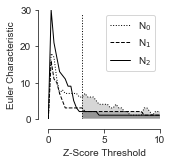

In [29]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n1_blob, linestyle = ':', label = 'N$_{0}$', linewidth = 1, color = 'k')
ax.plot(n_sigma, n2_blob, linestyle = '--', label = 'N$_{1}$', linewidth = 1, color = 'k')
ax.plot(n_sigma, n3_blob, linestyle = '-', label = 'N$_{2}$', linewidth = 1, color = 'k')
ax.plot(np.ones(30) * 3, np.arange(30), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n1_blob[sigma_mask],
    facecolor = 'k', 
    alpha = 0.16,
    clip_on = True
)

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n2_blob[sigma_mask],
    facecolor = 'k', 
    alpha = 0.16,
    clip_on = True
)

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n3_blob[sigma_mask],
    facecolor = 'k', 
    alpha = 0.16,
    clip_on = True
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 30)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.legend()

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 2)

plt.savefig(directories['figs'] + 'direction/' + 'DS Node EC vs Zscore.svg', dpi = 600)

N0

In [30]:
imshow_p['cmap'] = 'RdBu_r'

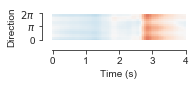

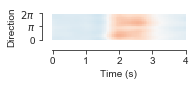

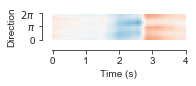

In [31]:
sns.set_style('ticks')

for itx, mu in enumerate([n1_c1_mu, n1_c2_mu, n1_diff_mu]):

    fig, ax = plt.subplots(1)
    ax.imshow(mu.T, **imshow_p)

    plt.yticks([0, 8, 16])
    ax.set_yticklabels(["0", "$\pi$", "$2\pi$"])
    ax.set_ylim(0, 16)
    ax.set_ylabel('Direction', fontsize = 10)

    plt.xticks(np.arange(0, 100, 20))
    ax.set_xticklabels(np.arange(0, 5, 1))
    ax.set_xlabel('Time (s)', fontsize = 10)

    sns.despine(ax = ax, offset = 10)

    fig.set_size_inches(2.4, 2)
    
    plt.savefig(directories['figs'] + 'direction/' + 'gp_diff_n0+{}.svg'.format(itx), dpi = 300)

N1

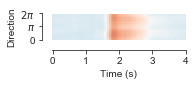

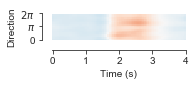

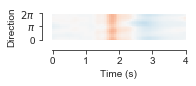

In [32]:
for itx, mu in enumerate([n2_c1_mu, n2_c2_mu, n2_diff_mu]):

    fig, ax = plt.subplots(1)
    ax.imshow(mu.T, **imshow_p)

    plt.yticks([0, 8, 16])
    ax.set_yticklabels(["0", "$\pi$", "$2\pi$"])
    ax.set_ylim(0, 16)
    ax.set_ylabel('Direction', fontsize = 10)

    plt.xticks(np.arange(0, 100, 20))
    ax.set_xticklabels(np.arange(0, 5, 1))
    ax.set_xlabel('Time (s)', fontsize = 10)

    sns.despine(ax = ax, offset = 10)

    fig.set_size_inches(2.4, 2)

    plt.savefig(directories['figs'] + 'direction/' + 'gp_diff_n1+{}.svg'.format(itx), dpi = 300)

N2

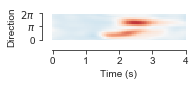

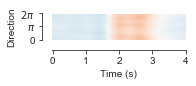

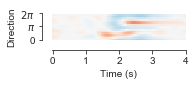

In [33]:
for itx, mu in enumerate([n3_c1_mu, n3_c2_mu, n3_diff_mu]):

    fig, ax = plt.subplots(1)
    
    ax.imshow(mu.T, **imshow_p)

    plt.yticks([0, 8, 16])
    ax.set_yticklabels(["0", "$\pi$", "$2\pi$"])
    ax.set_ylim(0, 16)
    ax.set_ylabel('Direction', fontsize = 10)

    plt.xticks(np.arange(0, 100, 20))
    ax.set_xticklabels(np.arange(0, 5, 1))
    ax.set_xlabel('Time (s)', fontsize = 10)

    sns.despine(ax = ax, offset = 10)

    fig.set_size_inches(2.4, 2)

    plt.savefig(directories['figs'] + 'direction/' + 'gp_diff_n2+{}.svg'.format(itx), dpi = 300)

Approximate Null Distribution

What is n1_B_y in this case?
Is the EC for 2D calculated the same way?
What is the GP model?

In [103]:
i_cluster

array([1, 4, 4, 1, 4, 1, 2, 4, 4, 2, 1, 3, 3, 1, 4, 1], dtype=int32)

In [104]:
Z = linkage(mu_flat.T, method = 'ward', metric = 'euclidean')

maxclust = 2
clusters = fcluster(Z, maxclust, criterion = 'maxclust')
cluster_df = ds_df.loc[ds_df['roi'].isin(i_rois[filter_mask][np.isin(clusters, [0, 1])]), :]
n1_B_x = np.concatenate([
        cluster_df['x_t'].values[:, None],
        cluster_df['x_cos'].values[:, None],
        cluster_df['x_sin'].values[:, None]
], axis = 1)
n1_B_y = cluster_df['y'].values[:, None]

maxclust = 3
clusters = fcluster(Z, maxclust, criterion = 'maxclust')
cluster_df = ds_df.loc[ds_df['roi'].isin(i_rois[filter_mask][np.isin(clusters, [1, 2])]), :]
n2_B_x = np.concatenate([
        cluster_df['x_t'].values[:, None],
        cluster_df['x_cos'].values[:, None],
        cluster_df['x_sin'].values[:, None]
], axis = 1)
n2_B_y = cluster_df['y'].values[:, None]

maxclust = 4
clusters = fcluster(Z, maxclust, criterion = 'maxclust')
cluster_df = ds_df.loc[ds_df['roi'].isin(i_rois[filter_mask][np.isin(clusters, [2, 3])]), :]
n3_B_x = np.concatenate([
        cluster_df['x_t'].values[:, None],
        cluster_df['x_cos'].values[:, None],
        cluster_df['x_sin'].values[:, None]
], axis = 1)
n3_B_y = cluster_df['y'].values[:, None]

In [112]:
import tqdm

n_blob_out = []

n_sigma = np.linspace(0, 5, 50)

for y_pool, x_new_pool in [(n1_B_y, n1_B_x), (n2_B_y, n2_B_x), (n3_B_y, n3_B_x)]:

    n_bootstrap = 500
    n_samples = 250

    array_shape = [n_bootstrap, X_predict.shape[0]]
    mB1_mu, mB1_sig = np.zeros(array_shape), np.zeros(array_shape)
    mB2_mu, mB2_sig = np.zeros(array_shape), np.zeros(array_shape)

    for itx in tqdm.tqdm(range(n_bootstrap)):
        np.random.seed(itx)

        all_boot_samples = np.random.choice(y_pool.shape[0], n_samples * 2, replace = False)

        B1_samples = all_boot_samples[:n_samples]
        B2_samples = all_boot_samples[n_samples:]

        k = GPy.kern.RBF(1, active_dims = [0,]) + \
        GPy.kern.RBF(2, active_dims = [1, 2], ARD = True) + \
        GPy.kern.RBF(1, active_dims = [0,]) * GPy.kern.RBF(2, active_dims = [1, 2], ARD = True)
            
        # Bootstrap 1
        mB1 = GPy.models.GPRegression(
            x_new_pool[B1_samples, :],
            y_pool[B1_samples],
            kernel = k,
        )

        mB1.optimize_restarts(1, max_iters = 10, verbose = False)

        mB1_mu_temp, mB1_sig_temp = mB1.predict(X_predict, include_likelihood = False)
        mB1_mu[itx, :] = mB1_mu_temp[:, 0]
        mB1_sig[itx, :] = mB1_sig_temp[:, 0]

        # Bootstrap 2
        mB2 = GPy.models.GPRegression(
            x_new_pool[B2_samples, :],
            y_pool[B2_samples],
            kernel = k,
        )

        mB2.optimize_restarts(1, max_iters = 10, verbose = False)

        mB2_mu_temp, mB2_sig_temp = mB2.predict(X_predict, include_likelihood = False)
        mB2_mu[itx, :] = mB2_mu_temp[:, 0]
        mB2_sig[itx, :] = mB2_sig_temp[:, 0]

    n_blob_bootstrap = np.zeros([n_bootstrap, n_sigma.shape[0]])

    for ity in tqdm.tqdm(range(n_bootstrap)):
        for itx, sigma in enumerate(n_sigma):
#             upper, lower = compute_bounds(mB1_mu[ity, :] - mB2_mu[ity, :], mB1_sig[ity, :] + mB2_sig[ity, :], n_sigma = sigma)

#             diff_mask = (upper < 0) | (lower > 0)

#             n_blob_bootstrap[ity, itx] = np.unique(np.hstack(np.unique(np.hstack(label(diff_mask))).max()[0])).max()

            nB_diff_mu = mB1_mu[ity, :].reshape(n_tpnts, n_orientations) - mB2_mu[ity, :].reshape(n_tpnts, n_orientations)
            nB_diff_sig = mB1_sig[ity, :].reshape(n_tpnts, n_orientations) + mB2_sig[ity, :].reshape(n_tpnts, n_orientations)
            nB_diff_upper = nB_diff_mu + sigma * np.sqrt(np.abs(nB_diff_sig))
            nB_diff_lower = nB_diff_mu - sigma * np.sqrt(np.abs(nB_diff_sig))

            labels = label((nB_diff_lower.T > 0) | (nB_diff_upper.T < 0), 
                           neighbors = 8, background = 1)

            n_blob_bootstrap[ity, itx] = np.unique(labels).shape[0] - 1
            
    n_blob_out.append(n_blob_bootstrap)



  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:01<12:36,  1.52s/it]

  0%|          | 2/500 [00:03<12:51,  1.55s/it]

  1%|          | 3/500 [00:04<12:42,  1.53s/it]

  1%|          | 4/500 [00:06<12:44,  1.54s/it]

  1%|          | 5/500 [00:08<14:53,  1.81s/it]

  1%|          | 6/500 [00:10<13:51,  1.68s/it]

  1%|▏         | 7/500 [00:11<13:07,  1.60s/it]

  2%|▏         | 8/500 [00:12<12:54,  1.57s/it]

  2%|▏         | 9/500 [00:14<13:11,  1.61s/it]

  2%|▏         | 10/500 [00:16<13:09,  1.61s/it]

  2%|▏         | 11/500 [00:17<12:41,  1.56s/it]

  2%|▏         | 12/500 [00:19<12:30,  1.54s/it]

  3%|▎         | 13/500 [00:20<13:10,  1.62s/it]

  3%|▎         | 14/500 [00:22<12:41,  1.57s/it]

  3%|▎         | 15/500 [00:24<12:52,  1.59s/it]

  3%|▎         | 16/500 [00:25<13:04,  1.62s/it]

  3%|▎         | 17/500 [00:27<13:02,  1.62s/it]

  4%|▎         | 18/500 [00:28<12:58,  1.62s/it]

  4%|▍         | 19/500 [00:30<12:24,  1.55s/it]

  4%|▍         |

 58%|█████▊    | 288/500 [07:43<05:48,  1.64s/it]

 58%|█████▊    | 289/500 [07:44<05:51,  1.67s/it]

 58%|█████▊    | 290/500 [07:46<06:11,  1.77s/it]

 58%|█████▊    | 291/500 [07:48<05:51,  1.68s/it]

 58%|█████▊    | 292/500 [07:49<05:44,  1.66s/it]

 59%|█████▊    | 293/500 [07:51<05:34,  1.61s/it]

 59%|█████▉    | 294/500 [07:53<06:16,  1.83s/it]

 59%|█████▉    | 295/500 [07:55<05:49,  1.70s/it]

 59%|█████▉    | 296/500 [07:56<05:26,  1.60s/it]

 59%|█████▉    | 297/500 [07:58<05:15,  1.56s/it]

 60%|█████▉    | 298/500 [07:59<05:32,  1.64s/it]

 60%|█████▉    | 299/500 [08:02<06:11,  1.85s/it]

 60%|██████    | 300/500 [08:03<05:54,  1.77s/it]

 60%|██████    | 301/500 [08:05<05:37,  1.69s/it]

 60%|██████    | 302/500 [08:07<05:50,  1.77s/it]

 61%|██████    | 303/500 [08:08<05:37,  1.71s/it]

 61%|██████    | 304/500 [08:10<05:46,  1.77s/it]

 61%|██████    | 305/500 [08:12<06:06,  1.88s/it]

 61%|██████    | 306/500 [08:14<05:43,  1.77s/it]

 61%|██████▏   | 307/500 [08:16

  9%|▉         | 44/500 [01:09<11:30,  1.51s/it]

  9%|▉         | 45/500 [01:11<11:32,  1.52s/it]

  9%|▉         | 46/500 [01:12<11:30,  1.52s/it]

  9%|▉         | 47/500 [01:13<11:15,  1.49s/it]

 10%|▉         | 48/500 [01:15<11:31,  1.53s/it]

 10%|▉         | 49/500 [01:17<11:19,  1.51s/it]

 10%|█         | 50/500 [01:18<11:22,  1.52s/it]

 10%|█         | 51/500 [01:19<11:04,  1.48s/it]

 10%|█         | 52/500 [01:21<10:50,  1.45s/it]

 11%|█         | 53/500 [01:22<10:45,  1.44s/it]

 11%|█         | 54/500 [01:24<11:07,  1.50s/it]

 11%|█         | 55/500 [01:25<11:16,  1.52s/it]

 11%|█         | 56/500 [01:27<11:04,  1.50s/it]

 11%|█▏        | 57/500 [01:28<10:53,  1.47s/it]

 12%|█▏        | 58/500 [01:30<11:44,  1.59s/it]

 12%|█▏        | 59/500 [01:32<11:44,  1.60s/it]

 12%|█▏        | 60/500 [01:33<11:28,  1.56s/it]

 12%|█▏        | 61/500 [01:35<11:09,  1.53s/it]

 12%|█▏        | 62/500 [01:37<11:57,  1.64s/it]

 13%|█▎        | 63/500 [01:38<11:35,  1.59s/it]



 66%|██████▌   | 331/500 [08:46<04:31,  1.61s/it]

 66%|██████▋   | 332/500 [08:47<04:24,  1.58s/it]

 67%|██████▋   | 333/500 [08:49<04:22,  1.57s/it]

 67%|██████▋   | 334/500 [08:50<04:18,  1.56s/it]

 67%|██████▋   | 335/500 [08:52<04:18,  1.57s/it]

 67%|██████▋   | 336/500 [08:54<04:35,  1.68s/it]

 67%|██████▋   | 337/500 [08:56<04:36,  1.70s/it]

 68%|██████▊   | 338/500 [08:57<04:28,  1.66s/it]

 68%|██████▊   | 339/500 [08:59<04:57,  1.85s/it]

 68%|██████▊   | 340/500 [09:01<04:39,  1.75s/it]

 68%|██████▊   | 341/500 [09:02<04:22,  1.65s/it]

 68%|██████▊   | 342/500 [09:04<04:25,  1.68s/it]

 69%|██████▊   | 343/500 [09:05<04:08,  1.58s/it]

 69%|██████▉   | 344/500 [09:07<03:57,  1.52s/it]

 69%|██████▉   | 345/500 [09:08<03:56,  1.52s/it]

 69%|██████▉   | 346/500 [09:10<03:55,  1.53s/it]

 69%|██████▉   | 347/500 [09:11<03:56,  1.55s/it]

 70%|██████▉   | 348/500 [09:13<03:53,  1.54s/it]

 70%|██████▉   | 349/500 [09:15<03:54,  1.55s/it]

 70%|███████   | 350/500 [09:16

 18%|█▊        | 89/500 [02:28<11:25,  1.67s/it]

 18%|█▊        | 90/500 [02:30<10:43,  1.57s/it]

 18%|█▊        | 91/500 [02:31<10:23,  1.53s/it]

 18%|█▊        | 92/500 [02:33<10:24,  1.53s/it]

 19%|█▊        | 93/500 [02:34<10:19,  1.52s/it]

 19%|█▉        | 94/500 [02:37<12:21,  1.83s/it]

 19%|█▉        | 95/500 [02:38<11:33,  1.71s/it]

 19%|█▉        | 96/500 [02:40<11:05,  1.65s/it]

 19%|█▉        | 97/500 [02:41<11:32,  1.72s/it]

 20%|█▉        | 98/500 [02:43<11:56,  1.78s/it]

 20%|█▉        | 99/500 [02:45<11:54,  1.78s/it]

 20%|██        | 100/500 [02:47<11:24,  1.71s/it]

 20%|██        | 101/500 [02:49<13:18,  2.00s/it]

 20%|██        | 102/500 [02:51<12:28,  1.88s/it]

 21%|██        | 103/500 [02:54<14:02,  2.12s/it]

 21%|██        | 104/500 [02:55<12:47,  1.94s/it]

 21%|██        | 105/500 [02:57<11:41,  1.78s/it]

 21%|██        | 106/500 [02:58<11:47,  1.80s/it]

 21%|██▏       | 107/500 [03:00<12:14,  1.87s/it]

 22%|██▏       | 108/500 [03:02<11:33,  1.

 75%|███████▌  | 375/500 [10:51<04:00,  1.92s/it]

 75%|███████▌  | 376/500 [10:52<03:38,  1.76s/it]

 75%|███████▌  | 377/500 [10:54<03:27,  1.69s/it]

 76%|███████▌  | 378/500 [10:57<04:01,  1.98s/it]

 76%|███████▌  | 379/500 [10:58<03:41,  1.83s/it]

 76%|███████▌  | 380/500 [11:00<03:54,  1.95s/it]

 76%|███████▌  | 381/500 [11:02<03:37,  1.83s/it]

 76%|███████▋  | 382/500 [11:04<03:37,  1.84s/it]

 77%|███████▋  | 383/500 [11:05<03:19,  1.71s/it]

 77%|███████▋  | 384/500 [11:07<03:35,  1.86s/it]

 77%|███████▋  | 385/500 [11:09<03:18,  1.73s/it]

 77%|███████▋  | 386/500 [11:11<03:32,  1.86s/it]

 77%|███████▋  | 387/500 [11:12<03:16,  1.74s/it]

 78%|███████▊  | 388/500 [11:14<03:03,  1.64s/it]

 78%|███████▊  | 389/500 [11:15<03:01,  1.64s/it]

 78%|███████▊  | 390/500 [11:17<03:05,  1.69s/it]

 78%|███████▊  | 391/500 [11:19<03:00,  1.66s/it]

 78%|███████▊  | 392/500 [11:21<03:05,  1.72s/it]

 79%|███████▊  | 393/500 [11:22<03:00,  1.68s/it]

 79%|███████▉  | 394/500 [11:25

In [133]:
from scipy.stats import percentileofscore

def calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma, sigma = 3):
    
    mask = n_sigma < sigma
    min_dim = np.min([n_blob_bootstrap.shape[-1], n_blob_inner.shape[0]])
    
    p_ = percentileofscore(
        n_blob_bootstrap[:min_dim, mask][:, -1], 
        n_blob_inner[:min_dim][mask][-1]
    )

    return p_

calc_boot_perc(n_blob_out[0], n1_blob, n_sigma)

100.0

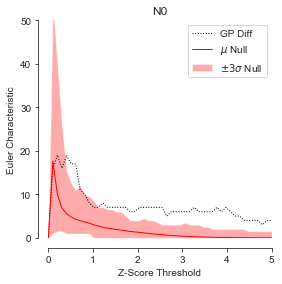

In [131]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

plt.title('N0', fontsize = 12)
ax.plot(n_sigma, n1_blob[:50], color = 'k', linewidth = 1, linestyle = ':', clip_on = True, label = 'GP Diff')
ax.plot(n_sigma, n_blob_out[0].mean(axis = 0), color = 'r', linewidth = 1, label = '$\mu$ Null');

ax.fill_between(
    n_sigma, 
    np.percentile(n_blob_out[0], 0.3, axis = 0), 
    np.percentile(n_blob_out[0], 99.7, axis = 0),
    facecolor = 'r', alpha = 0.33, clip_on = True,
    label = '$\u00B13\sigma$ Null'
)

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(0, 60, 10))
ax.set_xlim(0, 5)
ax.set_ylim(0, 50)
plt.legend()

sns.despine(ax = ax, offset = 10)
fig.set_size_inches(4, 4)

plt.savefig(directories['figs'] + 'bootstrap/' + 'DS-N0-bootstrap.svg', dpi = 300)

In [134]:
calc_boot_perc(n_blob_out[1], n2_blob, n_sigma)

99.0

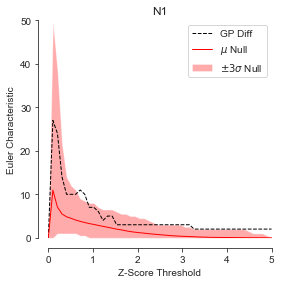

In [130]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

plt.title('N1', fontsize = 12)
ax.plot(n_sigma, n2_blob[:50], color = 'k', linewidth = 1, linestyle = '--', clip_on = True, label = 'GP Diff')
ax.plot(n_sigma, n_blob_out[1].mean(axis = 0), color = 'r', linewidth = 1, label = '$\mu$ Null');

ax.fill_between(
    n_sigma, 
    np.percentile(n_blob_out[1], 0.3, axis = 0), 
    np.percentile(n_blob_out[1], 99.7, axis = 0),
    facecolor = 'r', alpha = 0.33, clip_on = True,
    label = '$\u00B13\sigma$ Null'
)

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(0, 60, 10))
ax.set_xlim(0, 5)
ax.set_ylim(0, 50)
plt.legend()

sns.despine(ax = ax, offset = 10)
fig.set_size_inches(4, 4)

plt.savefig(directories['figs'] + 'bootstrap/' + 'DS-N1-bootstrap.svg', dpi = 300)

In [135]:
calc_boot_perc(n_blob_out[2], n3_blob, n_sigma)

100.0

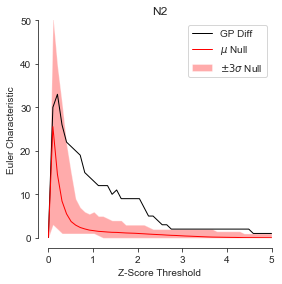

In [129]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

plt.title('N2', fontsize = 12)
ax.plot(n_sigma, n3_blob[:50], color = 'k', linewidth = 1, linestyle = '-', clip_on = True, label = 'GP Diff')
ax.plot(n_sigma, n_blob_out[2].mean(axis = 0), color = 'r', linewidth = 1, label = '$\mu$ Null');

ax.fill_between(
    n_sigma, 
    np.percentile(n_blob_out[2], 0.3, axis = 0), 
    np.percentile(n_blob_out[2], 99.7, axis = 0),
    facecolor = 'r', alpha = 0.33, clip_on = True,
    label = '$\u00B13\sigma$ Null'
)

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(0, 60, 10))
ax.set_xlim(0, 5)
ax.set_ylim(0, 50)
plt.legend()

sns.despine(ax = ax, offset = 10)
fig.set_size_inches(4, 4)

plt.savefig(directories['figs'] + 'bootstrap/' + 'DS-N2-bootstrap.svg', dpi = 300)

i_roi below needs to be checked

Approximate Null Distribution